In [4]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [5]:
MIN_LOOKBACK = max([
    21,  # EMA
    52,  # Ichimoku
    14,  # RSI
    14,  # Stochastic
    26,  # MACD
    20,  # Donchian
    20   # CMF
])

In [6]:
print(MIN_LOOKBACK)

52


In [7]:
df = pd.read_csv("../data/coinbaseUSD_1-min_data.csv", header=0)

df['Date'] = pd.to_datetime(df['Date'])

df = df[-250000:]
# Set 'Date' as the index
df.set_index('Date', inplace=True)
df = df.drop(['Symbol', 'Unix Timestamp'], axis=1)
df.rename(columns={
    "Open":"open",
    "High":"high",
    "Low":"low",
    "Close":"close",
    "Volume":"volume"
}, inplace=True)



In [8]:
df_temp = df.copy()

# Calculate Ichimoku using timestamp index
ichimoku_visible, ichimoku_forward = df_temp.ta.ichimoku(high=df_temp['high'], low=df_temp['low'], close=df_temp['close'], tenkan=7, kijun=22, senkou=44)

# Check the index of both results
print("Visible timeframe:")
print(ichimoku_visible.index[:5])
print("\nForward timeframe:")
print(ichimoku_forward.index[:5])

Visible timeframe:
DatetimeIndex(['2024-02-07 01:56:00+00:00', '2024-02-07 01:57:00+00:00',
               '2024-02-07 01:58:00+00:00', '2024-02-07 01:59:00+00:00',
               '2024-02-07 02:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', freq=None)

Forward timeframe:
DatetimeIndex(['2024-07-30 18:07:00+00:00', '2024-07-31 18:07:00+00:00',
               '2024-08-01 18:07:00+00:00', '2024-08-02 18:07:00+00:00',
               '2024-08-05 18:07:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='B')


In [31]:
ichimoku_visible[100:]

,ISA_7,ISB_22,ITS_7,IKS_22,ICS_22
Date,,,,,
2024-02-07 03:36:00+00:00,42999.3150,43019.475,42898.165,42932.560,42769.89
2024-02-07 03:37:00+00:00,42995.1975,43019.475,42879.445,42920.620,42774.76
2024-02-07 03:38:00+00:00,42993.2875,43019.475,42879.445,42920.620,42782.06
2024-02-07 03:39:00+00:00,42986.4275,43012.615,42866.985,42919.655,42792.25
2024-02-07 03:40:00+00:00,42986.4275,43012.615,42865.730,42919.490,42804.28
...,...,...,...,...,...
2024-07-29 18:03:00+00:00,66873.5925,66780.190,67082.745,67057.235,NaN
2024-07-29 18:04:00+00:00,66873.5925,66780.190,67097.710,67072.200,NaN
2024-07-29 18:05:00+00:00,66873.5925,66780.190,67097.710,67079.980,NaN


In [9]:
last_timestamp = df_temp.index[-1]
forward_timestamps = pd.date_range(start=pd.to_datetime(last_timestamp, unit='s'), 
                                 periods=len(ichimoku_forward),
                                 freq='1min')

# Set proper index for forward values
ichimoku_forward.index = forward_timestamps

In [10]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

In [11]:
# Technical indicators
df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)
df['RSI'] = ta.rsi(df.close, length=16)
df['RSI_8MIN'] = ta.rsi(df.close, length=8)
# my_bbands = ta.bbands(df.close, length=14, std=2.0)
macd = ta.macd(df.close)

# test_data = df[-55:]
# df = df[50:-55]

C:\Users\Pc\AppData\Local\Temp\ipykernel_18116\351530010.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)


In [12]:
df = pd.concat([df, macd], axis=1)

In [38]:
df.head()

,open,high,low,close,volume,VWAP,RSI,RSI_8MIN,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,
2024-02-07 01:56:00+00:00,43047.94,43050.10,43034.10,43047.19,3.596409,43043.796667,NaN,NaN,NaN,NaN,NaN
2024-02-07 01:57:00+00:00,43047.19,43047.20,43032.69,43038.88,5.058301,43041.338053,NaN,NaN,NaN,NaN,NaN
2024-02-07 01:58:00+00:00,43035.37,43039.57,43021.00,43034.90,3.855319,43038.405823,NaN,NaN,NaN,NaN,NaN
2024-02-07 01:59:00+00:00,43034.90,43037.38,43026.26,43033.78,2.252297,43037.500700,NaN,NaN,NaN,NaN,NaN
2024-02-07 02:00:00+00:00,43033.79,43063.52,43031.33,43044.51,8.420391,43040.752462,NaN,NaN,NaN,NaN,NaN


In [41]:
df.head(15)

,open,high,low,close,volume,VWAP,RSI,RSI_8MIN,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,
2024-02-07 01:56:00+00:00,43047.94,43050.10,43034.10,43047.19,3.596409,43043.796667,NaN,NaN,NaN,NaN,NaN
2024-02-07 01:57:00+00:00,43047.19,43047.20,43032.69,43038.88,5.058301,43041.338053,NaN,NaN,NaN,NaN,NaN
2024-02-07 01:58:00+00:00,43035.37,43039.57,43021.00,43034.90,3.855319,43038.405823,NaN,NaN,NaN,NaN,NaN
2024-02-07 01:59:00+00:00,43034.90,43037.38,43026.26,43033.78,2.252297,43037.500700,NaN,NaN,NaN,NaN,NaN
2024-02-07 02:00:00+00:00,43033.79,43063.52,43031.33,43044.51,8.420391,43040.752462,NaN,NaN,NaN,NaN,NaN
2024-02-07 02:01:00+00:00,43044.51,43045.61,43023.43,43044.28,4.383169,43040.278760,NaN,NaN,NaN,NaN,NaN
2024-02-07 02:02:00+00:00,43045.61,43061.73,43045.61,43056.09,2.146233,43041.304335,NaN,NaN,NaN,NaN,NaN
2024-02-07 02:03:00+00:00,43056.13,43064.90,43045.59,43050.75,2.886793,43042.406164,NaN,NaN,NaN,NaN,NaN
2024-02-07 02:04:00+00:00,43050.72,43059.89,43047.21,43055.71,2.143041,43043.137980,NaN,66.005974,NaN,NaN,NaN


                   open      high       low     close    volume      VWAP  \
open           1.000000  0.999982  0.999979  0.999969  0.004812  0.995701   
high           0.999982  1.000000  0.999964  0.999983  0.007501  0.995705   
low            0.999979  0.999964  1.000000  0.999982  0.001454  0.995638   
close          0.999969  0.999983  0.999982  1.000000  0.004518  0.995673   
volume         0.004812  0.007501  0.001454  0.004518  1.000000  0.007002   
VWAP           0.995701  0.995705  0.995638  0.995673  0.007002  1.000000   
RSI           -0.004891 -0.003701 -0.003292 -0.002471 -0.008171 -0.031919   
RSI_8MIN      -0.005064 -0.003489 -0.003174 -0.001944 -0.008938 -0.022605   
MACD_12_26_9   0.005278  0.005152  0.006274  0.005815 -0.076118 -0.034561   
MACDh_12_26_9 -0.001154 -0.000595 -0.000033  0.000310 -0.053660 -0.003144   
MACDs_12_26_9  0.005966  0.005655  0.006668  0.006071 -0.063730 -0.035686   

                    RSI  RSI_8MIN  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26

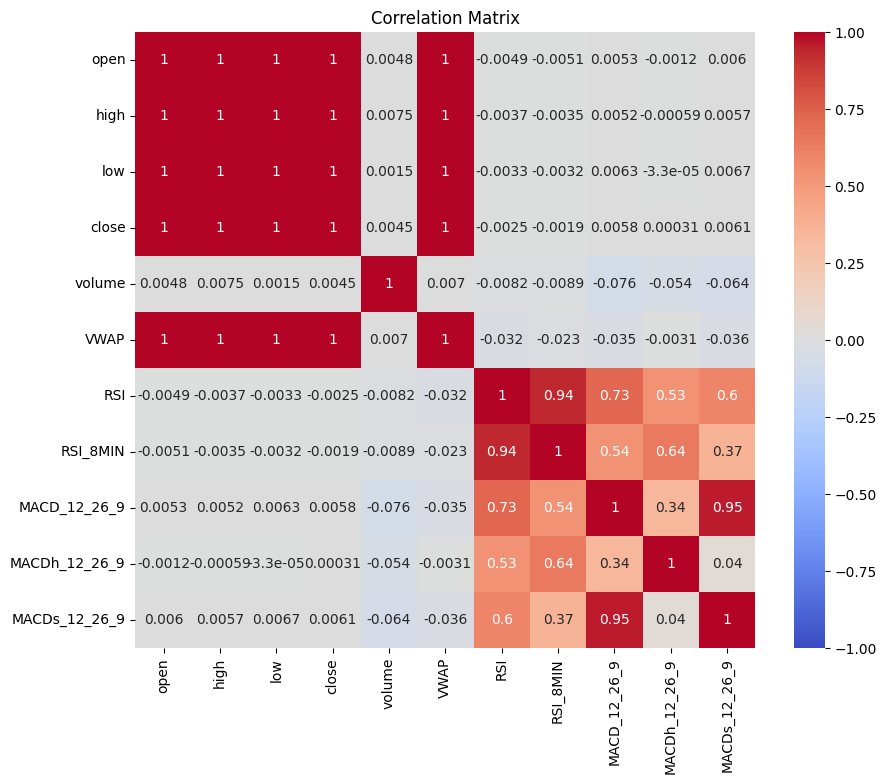

In [13]:
correlation_matrix = df[df.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [14]:
# Calculate Ichimoku indicators
ichimoku_visible, ichimoku_forward = df.ta.ichimoku(high=df['high'], low=df['low'], close=df['close'], tenkan=7, kijun=22, senkou=44)

# Add relevant Ichimoku columns from the 'visible' DataFrame to your main DataFrame
df['tenkan_sen'] = ichimoku_visible['ISA_7']
df['kijun_sen'] = ichimoku_visible['ISB_22']
df['span_a'] = ichimoku_visible['ITS_7']
df['span_b'] = ichimoku_visible['IKS_22']
df['chikou_span'] = ichimoku_visible['ICS_22']

In [15]:
def feature_engineering(df):
    # Видалення високо корельованих змінних
    
    # Створення нових ознак
    df['hl_range'] = df['high'] - df['low']
    df['oc_range'] = df['open'] - df['close']
    
    # Bollinger Bands
    # df['bb_width'] = (df['BBU_14_2.0'] - df['BBL_14_2.0']) / df['BBM_14_2.0']
    # df['bb_position'] = (df['close'] - df['BBL_14_2.0']) / (df['BBU_14_2.0'] - df['BBL_14_2.0'])
    
    # Логарифмічні різниці
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['log_volume_change'] = np.log(df['volume'] / df['volume'].shift(1))
        
    df['close_vwap_ratio'] = df['close'] / df['VWAP'] - 1
    
    # Зміна VWAP
    df['vwap_change'] = df['VWAP'].pct_change()
                   
    # Обчислення SMA та EMA
    df['SMA_10'] = df['close'].rolling(window=7).mean()
    df['EMA_5'] = df['close'].ewm(span=4, adjust=False).mean()
    
    # Відносне положення ціни закриття між SMA та EMA
    df['close_between_ma'] = (df['close'] - df['SMA_10']) / (df['EMA_5'] - df['SMA_10'])
    
    # Різниця між EMA та SMA
    df['ema_sma_diff'] = df['EMA_5'] - df['SMA_10']
            
    # Нахил SMA та EMA
    df['sma_slope'] = (df['SMA_10'] - df['SMA_10'].shift(1)) / df['SMA_10'].shift(1)
    df['ema_slope'] = (df['EMA_5'] - df['EMA_5'].shift(1)) / df['EMA_5'].shift(1)
     
    df = df.drop(['EMA_5', 'SMA_10', 'VWAP','high', 'open', 'low'], axis=1)
    



    return df

In [ ]:
# # Calculate Ichimoku indicators
# ichimoku_visible, ichimoku_forward = df.ta.ichimoku(high=df['high'], low=df['low'], close=df['close'], tenkan=7, kijun=22, senkou=44)

# # Add relevant Ichimoku columns from the 'visible' DataFrame to your main DataFrame
# df['tenkan_sen'] = ichimoku_visible['ISA_7']
# df['kijun_sen'] = ichimoku_visible['ISB_22']
# df['span_a'] = ichimoku_visible['ITS_7']
# df['span_b'] = ichimoku_visible['IKS_22']
# df['chikou_span'] = ichimoku_visible['ICS_22']



In [ ]:
# last_timestamp = df_temp.index[-1]
# forward_timestamps = pd.date_range(start=pd.to_datetime(last_timestamp, unit='s'), 
#                                  periods=len(ichimoku_forward),
#                                  freq='1min')

# # Set proper index for forward values
# ichimoku_forward.index = forward_timestamps

In [16]:
df_engineered = feature_engineering(df)

                      close    volume       RSI  RSI_8MIN  MACD_12_26_9  \
close              1.000000  0.004518 -0.002471 -0.001944      0.005815   
volume             0.004518  1.000000 -0.008171 -0.008938     -0.076118   
RSI               -0.002471 -0.008171  1.000000  0.935521      0.726199   
RSI_8MIN          -0.001944 -0.008938  0.935521  1.000000      0.537541   
MACD_12_26_9       0.005815 -0.076118  0.726199  0.537541      1.000000   
MACDh_12_26_9      0.000310 -0.053660  0.532377  0.644613      0.336840   
MACDs_12_26_9      0.006071 -0.063730  0.601523  0.365658      0.954204   
tenkan_sen         0.999271  0.006906 -0.031382 -0.024683     -0.030890   
kijun_sen          0.999024  0.006650 -0.033411 -0.024559     -0.034990   
span_a             0.999941  0.004698 -0.008813 -0.009615      0.002792   
span_b             0.999824  0.004905 -0.016956 -0.016174     -0.007994   
chikou_span        0.999363  0.004682 -0.002554 -0.002132      0.005603   
hl_range           0.1061

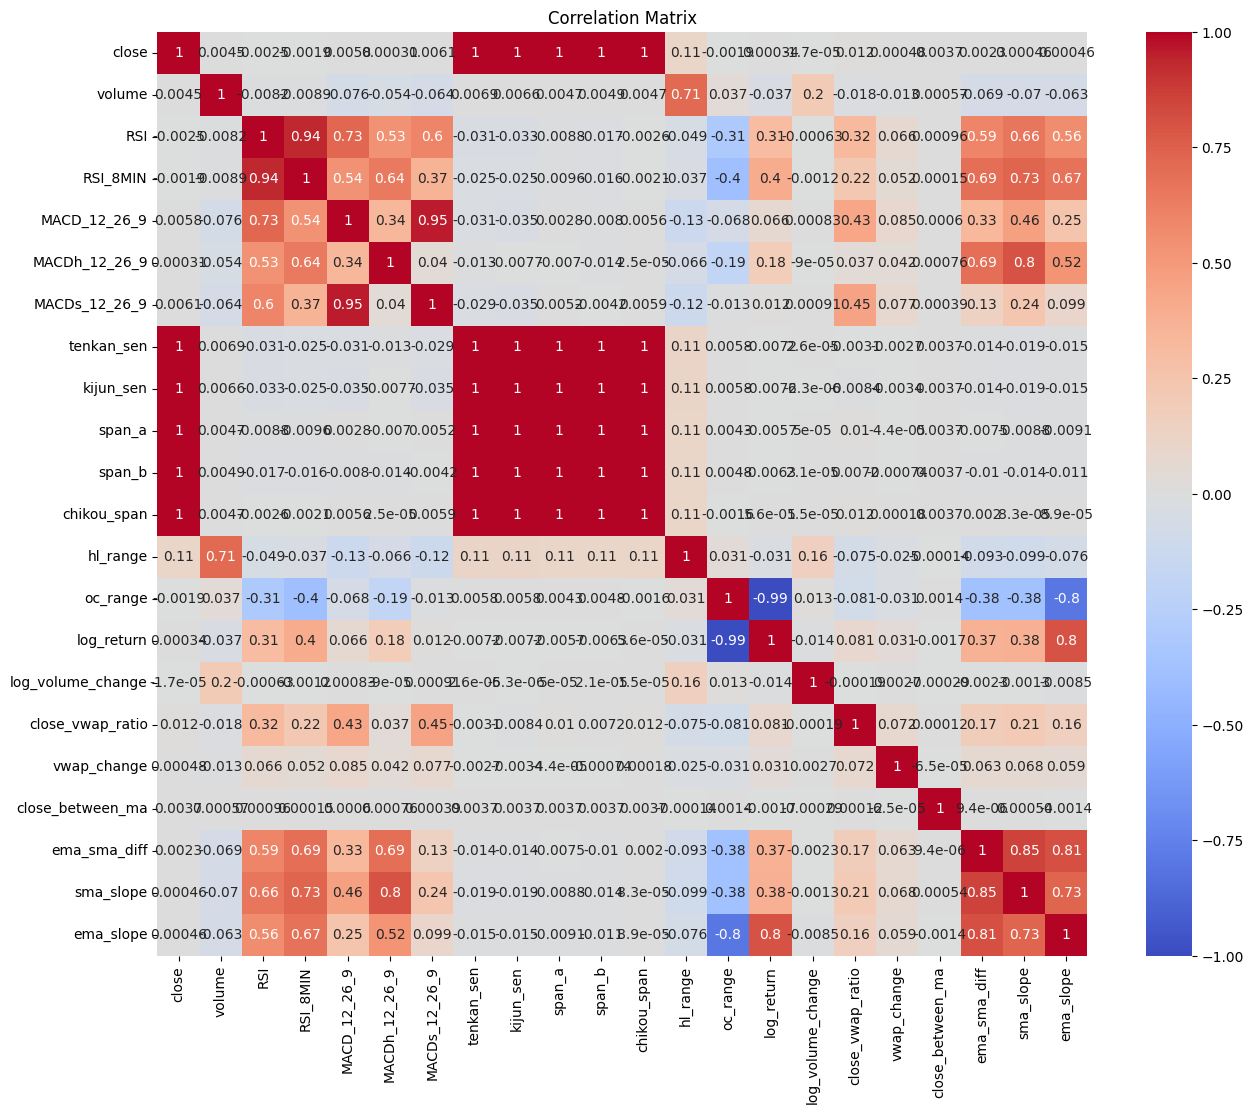

In [17]:
correlation_matrix = df_engineered[df_engineered.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [53]:
df_engineered.describe()

,close,volume,RSI,RSI_8MIN,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,oc_range,log_return,log_volume_change,close_vwap_ratio,vwap_change,close_between_ma,ema_sma_diff,sma_slope,ema_slope
count,250000.000000,250000.000000,249984.000000,249992.000000,249975.000000,249967.000000,249967.000000,250000.000000,2.499990e+05,2.499990e+05,250000.000000,2.499990e+05,249994.000000,249994.000000,249993.000000,249999.000000
mean,63576.662815,9.614101,50.345346,50.356304,0.671499,0.000823,0.670706,-0.262995,1.786507e-06,5.776637e-07,0.000641,1.916580e-06,0.747368,0.145283,0.000002,0.000002
std,6149.250806,17.910404,10.332888,14.917370,53.078645,15.891566,50.017133,48.219922,7.566510e-04,9.245212e-01,0.008991,3.316551e-04,602.077286,32.090270,0.000280,0.000373
min,42769.890000,0.002111,5.916320,2.257521,-1070.759079,-363.217157,-934.344620,-1191.100000,-2.981234e-02,-6.052381e+00,-0.089716,-3.382570e-02,-296003.104122,-760.220270,-0.007432,-0.014613
25%,61248.620000,1.850660,43.373613,39.824930,-20.350805,-6.963348,-19.174111,-20.710000,-3.238324e-04,-5.648784e-01,-0.003275,-4.034558e-06,1.245852,-13.242087,-0.000117,-0.000154
50%,64907.560000,4.316307,50.252042,50.280962,0.739418,-0.074839,0.683688,-0.050000,1.477193e-07,-1.590039e-02,0.000408,3.273667e-07,1.888443,0.222770,0.000002,0.000003
75%,67892.422500,10.328698,57.256954,60.860798,22.904282,6.873714,21.526116,20.180000,3.281186e-04,5.453462e-01,0.004280,5.702607e-06,2.550096,13.866996,0.000124,0.000161
max,73815.430000,737.545781,93.506022,97.593469,575.196302,196.867094,528.436728,1818.920000,1.920693e-02,8.597238e+00,0.066007,5.823382e-02,21563.053897,530.023062,0.005042,0.007168


In [54]:

df_numeric = df_engineered.select_dtypes(include=[np.number])

# Define a scaler for features (all columns)
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = feature_scaler.fit_transform(df_numeric)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Припустимо, що у вас є датасет з 7 ознак, включаючи "close"
seq_length = 50
pred_length = 5

# Створюємо функцію для підготовки послідовностей
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])  # 50 рядків для навчання
        y.append(data[i+seq_length:i+seq_length+pred_length, 3])  # Прогнозуємо "close" (індекс 3)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length, pred_length)

# Кастомна функція втрат (MSE між двома векторами з 5 елементів)
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return mse

# Створюємо модель LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(pred_length)  # Передбачаємо 5 наступних значень "close"
])

# Використовуємо кастомну функцію втрат
model.compile(optimizer='adam', loss=custom_loss)

# Навчання моделі
history = model.fit(X, y, epochs=10, batch_size=32)

# Прогнозуємо на останньому вікні і можемо перевірити на реальних даних
last_sequence = X[-1]  # Беремо останні 50 кроків
predicted_close = model.predict(last_sequence[np.newaxis, :, :])
predicted_close = scaler.inverse_transform(predicted_close)  # Масштабуємо назад

# Виводимо результати
print("Прогнозовані 5 значень 'close':", predicted_close)
print("Реальні 5 значень 'close':", df[-5:, 3])

Epoch 1/10
2149/7811 [=======>......................] - ETA: 1:19 - loss: nan

KeyboardInterrupt: 

: 